# Cartographie des tombes de Kerma


Les points à remarquer:
* la part importante prise par le nettoyage des données (le codage présuppose un modèle)
* les choix de la visualisation (le modèle produit par le logiciel de SIG)


Les Systèmes d'Information Géographique (SIG):
* [Système d'information géographique](https://fr.wikipedia.org/wiki/Syst%C3%A8me_d%27information_g%C3%A9ographique) (Wikipedia)
* [Qu'est-ce qu'un SIG ?](https://www.unil.ch/gis/home/menuinst/introduction/quest-ce-quun-sig.html) (UNIL)
* [Géoïde](https://fr.wikipedia.org/wiki/G%C3%A9o%C3%AFde) : la terre n'est pas sphérique
* [WGS84](https://fr.wikipedia.org/wiki/WGS_84) : le système de coordonnées géographiques actuellement uilisé

In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

In [3]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple,
    SelectionRangeSlider, Layout,
    jslink, fixed,
    HTML, HBox)

In [4]:
from ipyleaflet import (Map,
                        Marker,
                        basemap_to_tiles,
                        basemaps,
                        CircleMarker,
                        MarkerCluster,
                        LayerGroup, 
                        LayersControl,
                        WidgetControl,
                        Popup,
                        ScaleControl,
                        projections
                       )

In [5]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement
import sparql_functions as spqf

In [7]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  reload(spqf)

<module 'sparql_functions' from '/Volumes/Patientia/python_notebooks/sciences_historiques_numeriques/histoire_numerique/sparql/sparql_functions.py'>

## Base de données

In [6]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/KERMA_CE_copie.sqlite'

In [8]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210519_205513'

In [9]:
##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [10]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210519_103510.sqlite'

###Insertion des coordonnées dans la BDD



In [8]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/KERMA_CE_copie.db'

In [12]:
#ajout de colonnes à la base de données
#vu sur https://moonbooks.org/Articles/Ajouter-une-colonne-%C3%A0-une-table-existante-avec-sqlite-et-python/

cn = sql.connect(db)
c = cn.cursor()
c.execute('ALTER TABLE T_Tombes ADD COLUMN Coord_X INTEGER')
c.execute('ALTER TABLE T_Tombes ADD COLUMN Coord_Y INTEGER')
cn.close()


In [7]:
#lire une feuille excel et en extraire les données
#wb = pd.read_excel('CPS\CPS.xlsx',sheet_name = None)
## écrire le résultat puis l'ouvrir dans Calc ou Excel afin d'effectuer le codage
file= 'data/Tombes_Coord.csv'
file_cont = []
with open(file, newline='') as csvfile:
    read = csv.reader(csvfile, delimiter=';', quotechar='"')
    for row in read:
        file_cont.append(row)

In [8]:
print(len(file_cont))
file_cont[0]
#la colonne IDTombe a la position 10, point_X la 18 et point_y la 19
print(file_cont[5][10],file_cont[5][18],file_cont[5][19])
type(file_cont[5][18])
#les coordonnées sont de type string, j'imagine que pour faire des carte il est bien de les convertir en float
x=float(file_cont[5][18])
y=float(file_cont[5][19])

733
7 30.4441013 19.61509519


In [9]:
#création d'une liste comprenant les IDTOMBES avec leurs coordonnées
tcoord=[]
for i in range (0, len(file_cont)):
    tombe=(file_cont[i][10],file_cont[i][18],file_cont[i][19])
    tcoord.append(tombe)
tcoord[5]

('7', '30.4441013', '19.61509519')

In [10]:
#Affichage joli
tombes = pd.DataFrame(tcoord[1:], columns = tcoord[0])
tombes.head()

,IDTombe,POINT_X,POINT_Y
0,3,30.44414317,19.61528858
1,4,30.44411848,19.61513045
2,5,30.44414632,19.61498164
3,6,30.44413629,19.61510432
4,7,30.4441013,19.61509519


In [14]:
len(tcoord)-1

732

In [15]:
#Faire une boucle pour attribuer ces valeurs aux tombes appropriées
# connnexion à la base de données
db = 'data/KERMA_CE_copie.sqlite'
conn = sql.connect(db)
c = conn.cursor()

#Boucle qui commence à 1 car la ligne 0 contient les entêtes
for i in range (1, 732):
    idtombe=tcoord[i][0]
    x=tcoord[i][1]
    y=tcoord[i][2]

    tex=("UPDATE T_Tombes SET Coord_X ="+x+" WHERE IDTombe ="+str(idtombe))
    tey=("UPDATE T_Tombes SET Coord_Y ="+y+" WHERE IDTombe ="+str(idtombe))
    c.execute(tex)
    c.execute(tey)

#Tentative infructueuses tant que j'avais oublié les "()" après le commit, je trouve dommage de les jeter
#    tex=("UPDATE T_Tombes SET Coord_X ="+str(x)" WHERE IDTombe ="+str(idtombe))
#    tey=("UPDATE T_Tombes SET Coord_Y ="+str(y)" WHERE IDTombe ="+str(idtombe))
#    query_update_rowx = "UPDATE T_Tombes SET Coord_X =:x WHERE IDTombe = :idtombe"
#    query_update_rowy = "UPDATE T_Tombes SET Coord_Y=:y WHERE IDTombe = :idtombe"
#    c.execute(query_update_rowx, {x: x, idtombe: idtombe})
#    c.execute(query_update_rowy, {y: y, idtombe: idtombe})
    
#    c.execute(query_update_rowx, {tcoord[i][1]: x, tcoord[i][0]: idtombe})
#    c.execute(query_update_rowy, {tcoord[i][2]: y, tcoord[i][0]: idtombe})
#!!!!!!!!mis en commentaire pour éviter que ça réaffecte la base de données!!!!!#     conn.commit()
#fermer la connexion
conn.close()


### extraire des données de la BDD

In [11]:
### Liste des tombes avec coordonnées géographiques
lieux = """SELECT IDTombe, Coord_X, Coord_Y
FROM T_Tombes 
"""

In [14]:
### Liste complete: personne, lieu, type, coordonnées géo
personnes_lieux_naissance = """
SELECT e.uri_entity, 
p4.value birth_year,
 REPLACE(REPLACE(p.value, 'http://dbpedia.org/resource/', ''), '_', ' ') place_name, 
REPLACE(p3.value, 'http://dbpedia.org/ontology/', '') place_type, 
p1.value longitude, p2.value latitude
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND p.property LIKE '%BirthPlace%'
  LEFT JOIN property p1 ON p1.uri_entity = p.value AND p1.property LIKE '%long'
  LEFT JOIN property p2 ON p2.uri_entity = p.value AND p2.property LIKE '%lat'
  LEFT JOIN property p3 ON p3.uri_entity = p.value AND p3.property LIKE '%type%'
  LEFT JOIN property p4 ON p4.uri_entity = e.uri_entity AND p4.property LIKE '%irthYe%' AND p4."source" LIKE '%8 mai 2021%'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Person'
AND longitude IS NOT NULL;
"""

In [12]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
# attention au nom de la requête !
c.execute(lieux)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:4]

732


[(3, 30.44414317, 19.61528858),
 (4, 30.44411848, 19.61513045),
 (5, 30.44414632, 19.61498164),
 (6, 30.44413629, 19.61510432)]

In [13]:
tombes = pd.DataFrame(result_q, columns =tcoord[0])
tombes.head()

,IDTombe,POINT_X,POINT_Y
0,3,30.444143,19.615289
1,4,30.444118,19.615130
2,5,30.444146,19.614982
3,6,30.444136,19.615104
4,7,30.444101,19.615095


### Produire les données à projeter sur une carte

### Données à cartographier concernant les Universités

In [14]:
tombes.to_csv('maps/tombes.csv', sep=';')

In [15]:
### Importer le CSV et mettre son contenu dans la variable 'place_count' 
# au cas où on ne souhaite pas répéter toutes les opérations précédentes
tb = pd.read_csv('maps/tombes.csv', sep=';', index_col=[0])
tb.head()

,IDTombe,POINT_X,POINT_Y
0,3,30.444143,19.615289
1,4,30.444118,19.615130
2,5,30.444146,19.614982
3,6,30.444136,19.615104
4,7,30.444101,19.615095


# Créer une carte



Nous utilisons ici la librairie __[ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/): Interactive maps in the Jupyter notebook__
* Installation : [JupyterLab extension](https://ipyleaflet.readthedocs.io/en/latest/installation.html#jupyterlab-extension)


D'autres librairies existent telles que Folium, [GeoPandas](https://geopandas.org/), etc.



Voir le tutoriel de [Programming Historian](https://programminghistorian.org/en/lessons/mapping-with-python-leaflet) à ce sujet

## Choisir d'abord un fonds de carte adapté

In [18]:
#importer librairie pour pouvoir choisir le système de coordonnées
import pyproj

In [26]:
## trois exemples sont proposés ici, bien d'autres existent

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
#J'attribue plusieurs projection, au cas où. Source: https://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/
wgs84=projections.EPSG4326 # LatLon with WGS84 datum used by GPS units and Google Earth 
osgb36=pyproj.CRS("EPSG:27700") # UK Ordnance Survey, 1936 datum 
UTM26N=pyproj.CRS("EPSG:32626") # UTM coords, zone 26N, WGS84 datum 
UTM27N=pyproj.CRS("EPSG:32627") # UTM coords, zone 27N, WGS84 datum 


In [20]:
## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(basemap=(esri_sat), center=(19.641818429971575, 30.41728879519245), layout=Layout(width='100%', height='600px'),\
        zoom_control=True  , zoom=4 #, scroll_wheel_zoom=True
       )

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

m1


Map(center=[19.641818429971575, 30.41728879519245], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [66]:
#Test pour voir comment fonctionne l'ajout de Markers
markers = []

# lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
tomb=Marker(location=(19.641818429971575, 30.41728879519245), title="truf")
markers.append(tomb)
mark=Marker(location=(19.641818429971700, 30.41728879519300), title="furt")
markers.append(mark)
lg1 = MarkerCluster(name='Tombes', markers=markers)
print(markers)
#m1.add_layer(lg1)
#m1

[Marker(location=[19.641818429971575, 30.41728879519245], options=['alt', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'rotation_angle', 'rotation_origin', 'title', 'z_index_offset'], title='truf'), Marker(location=[19.6418184299717, 30.417288795193], options=['alt', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'rotation_angle', 'rotation_origin', 'title', 'z_index_offset'], title='furt')]


## Affichage de la carte

In [60]:
#essaie pour comprendre le fonctionnement
tb['POINT_Y'][2]

19.61498164

In [28]:
#création du fond de carte
## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(layers=(esri_sat, open_street_map), center=(tb['POINT_Y'][11], tb['POINT_X'][11]), layout=Layout(width='100%', height='600px'),\
        zoom_control=True  , zoom=17 #, scroll_wheel_zoom=True
       )

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

#création de la couche contenant les tombes
mark=[]
for i in tb.index:
    mk=CircleMarker(location=(tb['POINT_Y'][i],tb['POINT_X'][i]), title=(str(tb['IDTombe'][i])), radius=0)
    mark.append(mk)
#print(mark[:3])
lg = LayerGroup(name = 'Tombes', layers = mark)

mc = MarkerCluster(markers=(mark[0:731]))
m1.add_layer(lg);
m1

Map(center=[19.61501654, 30.44412842], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…

C'est dommage, on ne peut pas zoomer assez pour voir les emplacements des tombes. je vais encore effectuer quelques recherches pour vois si c'est possible d'avoir une résolution plus précise

### Ajouter la couche avec les Universités

In [136]:
## Parcourir le DataFrame et extraire les valeurs
#  i = index, v = valeur

markers = []
for i,v in tb.iterrows():
    marker = Marker(location=(v['POINT_Y'], v['POINT_X']), draggable=False,\
                    title=  "tombes")
                    
    
    markers.append(marker)


print("Markers' number " + str(len(markers)))

lg2 = MarkerCluster(name='TOMBES2', markers=markers)

m1.add_layer(lg2)

Markers' number 732


ModuleNotFoundError: No module named 'basemap'

In [175]:
# Create a map using Stamen Terrain, centered on Boulder, CO
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m = Map(layers=(open_street_map,), location=[19, 30])
# Add marker for Boulder, CO
Marker(
    location=[40.009515, -105.242714], # coordinates for the marker (Earth Lab at CU Boulder)
).add_to(m)

# Display m
m


AttributeError: 'Marker' object has no attribute 'add_to'

In [177]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

### Ajouter les couches des Universités par tranches chronologiques

In [98]:
idx = 0
for p in liste_periodes:    
    markers = []
    print(p)
    for i,v in gb_periode_uni.iterrows():
        if p == v['periode']:
            circle = CircleMarker(location=(v['lat'], v['long']), color=col_list[idx], name=f"{v['university_name']}", \
                              radius = int(math.log((v['effectif'] + 1) * 3, 2)), weight=1)
            # message.value = f"<h4>{j['place_name']} ({j['count_persons']})</h4>" + p_elements
            # a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))
            message = HTML()
            message.value = f"{v['university_name']} ({v['effectif']})"

            a = HBox([message], layout=Layout(width='100px', height='200px', overflow="auto")) # overflow_y='auto',

            circle.popup = a
        
            markers.append(circle)


    print("Markers' number " + str(len(markers)))

    # lg = MarkerCluster(name='Universités (' + v['periode'] +')', markers=markers)
    my_dict[idx] = LayerGroup(name='Universités (' + p +')', layers=(markers))
    
    m1.add_layer(my_dict[idx])
    idx += 1

1771-1861
Markers' number 49
1861-1901
Markers' number 98
1901-1921
Markers' number 128
1921-1941
Markers' number 265
1941-1951
Markers' number 332
1951-1961
Markers' number 322
1961-1971
Markers' number 265
1971-2001
Markers' number 126


### Enregistrer et afficher la carte au format HTML

In [161]:
m1.save('maps/tb.html', title='tombes de la nécropole de Kerma')

In [162]:
from IPython.display import IFrame

In [165]:
IFrame(src='./maps/tb.html', width='90%', height=600)

## Créer une carte interactive

* La librairie pour les visualisations interactives : __[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html)__


In [51]:
def update_layer(m, begin_end, color):
    
    # [m.remove_layer(n) for n in m.layers if n.name in ['Clusters', 'Flat locs']]
    
    [m.remove_control(n) for n in m.controls if 'LayersControl' in str(type(n)) ]
    
    ## zoom ne marche pas 
    print(m.zoom)    
    begin = begin_end[0]
    end = begin_end[1]
    x = df_lnu[(df_lnu['birth_year'] >= begin) \
                  & (df_lnu['birth_year'] <= end)]   # .astype(int)
    xgb = x.groupby(['place_name', 'place_type', 'long', 'lat'], as_index=False) \
      .agg({'concat_person': '##'.join, 'uri_entity': 'count'})
    place_count = xgb.rename(columns={'uri_entity': 'count_persons'})


    markers = []
    popups = []
    

    ## Extraire les lignes du DataFrame
    for i,j in place_count.iterrows():
        message = HTML()
        p_elements = ''
        for z in j['concat_person'].split('##'):
            if '|' in z:
                zs = z.split('|')
                p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
            else:
                p_elements = ''

        message.value = f"<h4>{j['place_name']} ({j['count_persons']})</h4>" + p_elements
        a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


        circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_name']}", \
                              fill_color=color, radius = int(math.log((j['count_persons'] + 1) * m.zoom * 2,  2)), weight=1)

        circle.popup = a
        
        markers.append(circle)


    print("Markers' number " + str(len(markers)))
    
    name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'
    
    lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
    # lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

    m.add_layer(lg1)
    # m.add_layer(lg2)
    
    control = LayersControl(name='layCont', position='topright')
    m.add_control(control)
    return n_iterations


In [52]:
df_year_set = sorted(list(set(df_lnu['birth_year'].astype(int))))
print(len(df_year_set))
min_y = min(df_year_set)
max_y = max(df_year_set)
i = 0
srs = SelectionRangeSlider(
    options=df_year_set,
    index=(0, len(df_year_set)-1), # -1
    description='Years', 
    continous_update=False, 
    layout= Layout(width='90%')
    # , disabled=False
)


203


In [53]:
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m = Map(layers=(watercolor,open_street_map), center=(45, 15), layout=Layout(width='100%', height='600px'),\
        zoom_control=False 
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m.add_control(widget_control1)

m



Map(center=[45, 15], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Wid…

In [54]:
### https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
n_iterations = 0
colors = ['blue', 'red', 'black', 'purple', 'yellow' ]

a = interactive(update_layer, {'manual':True}, m = fixed(m), color = colors, begin_end = srs);
display(a)

interactive(children=(SelectionRangeSlider(description='Years', index=(0, 202), layout=Layout(width='90%'), op…

In [72]:
### Seule la carte est enregistrée, pas les points
# m.save('maps/birth_place_years.html', title='Birth places')

### Explorer la distribution des naissances dans le temps pour visualiser les générations (ou sur la carte

In [341]:
min(df_lnu['birth_year']),max(df_lnu['birth_year'])

(1771, 2000)

In [358]:
y10_list = pd.RangeIndex(start=min(df_lnu['birth_year']), stop=max(df_lnu['birth_year'])+2, step=10).to_list()
y10_list[-3:]

[1981, 1991, 2001]

In [359]:
### codeer les années les regroupant par décennies : fonction cut

df_lnu['decennie'] = pd.cut(df_lnu['birth_year'], y10_list, right=False)
df_lnu['decennie'] = df_lnu['decennie'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
df_lnu.head()

,uri_entity,place_name,place_type,long,lat,birth_year,person,concat_person,decennie
0,http://dbpedia.org/resource/A._C._Cuza,Iași,AdministrativeRegion,27.5903,47.1569,1857,A. C. Cuza,http://dbpedia.org/resource/A._C._Cuza|A. C. C...,1851-1861
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,Chennai,City,80.275,13.0827,1956,A. K. Shiva Kumar,http://dbpedia.org/resource/A._K._Shiva_Kumar|...,1951-1961
2,http://dbpedia.org/resource/Aaron_Director,Staryi Chortoryisk,Village,25.8825,51.2242,1901,Aaron Director,http://dbpedia.org/resource/Aaron_Director|Aar...,1901-1911
3,http://dbpedia.org/resource/Aat_van_Rhijn,Groningen,City,6.56667,53.2167,1892,Aat van Rhijn,http://dbpedia.org/resource/Aat_van_Rhijn|Aat ...,1891-1901
4,http://dbpedia.org/resource/Abass_Bundu,Gbinti,,-12.6,8.96667,1948,Abass Bundu,http://dbpedia.org/resource/Abass_Bundu|Abass ...,1941-1951


In [360]:
### Regrouper par continent et compter avec la fonction Pandas 'groupby'
gb_decennie = df_lnu.groupby('decennie').size()
gb_decennie[-5:]

decennie
1951-1961    492
1961-1971    344
1971-1981    121
1981-1991     21
1991-2001    203
dtype: int64

['1771-1781', '1781-1791', '1791-1801', '1801-1811', '1811-1821']


<BarContainer object of 23 artists>

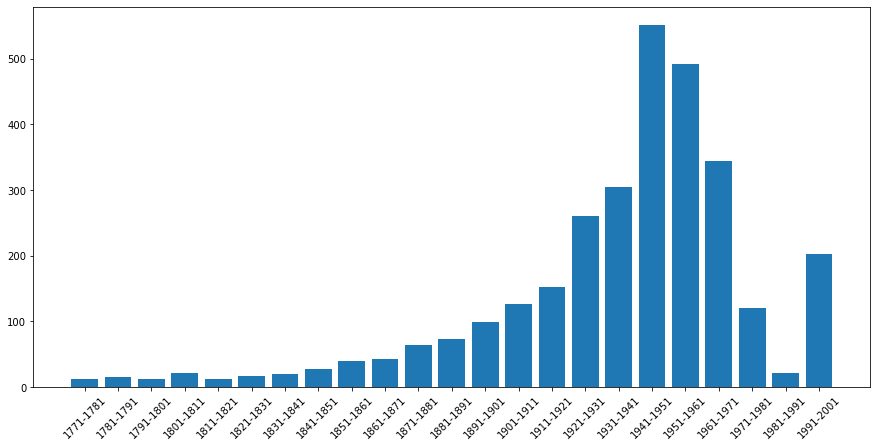

In [361]:
### Distribution des naissances par décennie

objects = [l for l in gb_decennie.index]
eff = [l for l in gb_decennie]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.bar(objects, eff)